In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
from brs.ingestion import LoadLocalDataset

lld = LoadLocalDataset()

data_books = lld.load_dataset("books")
data_users = lld.load_dataset("users")
data_ratings = lld.load_dataset("ratings")

d:\z\Conspects\_Summer\BRS\brs\ingestion\load_local.py:42: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(dataset_path)


## Датасет с пользователями data_users

In [3]:
print(data_users.count())
data_users.head()

User-ID     278858
Location    278858
Age         168096
dtype: int64


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Посмотрим для начала на пропуски в данных.

Тут стоит обратить внимание на то, что в Location пропусков нет, но там иногда встречаются странные результаты. Хочется из всех Location вытащить страны, но не везде это возможно. Иногда адреса неполные

In [4]:

from brs.analysis import NAInspection

NAInspection(dataset_name="users").inspect(data_users)



print(f"\nПример странного адреса: '{data_users.iloc[18]["Location"]}'")

users total size 278858
          NaN count   NaN %
User-ID           0    0.0%
Location          0    0.0%
Age          110762  39.72%

Пример странного адреса: 'weston, ,'


Заметим, что у нас есть очевидные выбросы в виде каких-то подозрительно старых и молодых читателе

Number of very young users: 908
Number of very old users: 366


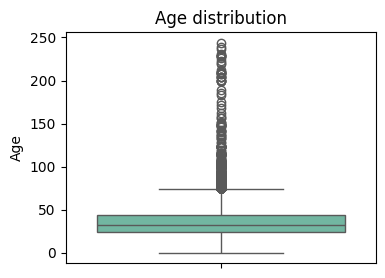

In [5]:
from brs.analysis import BoxPlotInspection

print(f"Number of very young users: {(data_users["Age"] < 6).sum()}")
print(f"Number of very old users: {(data_users["Age"] > 100).sum()}")
BoxPlotInspection("Age", title="Age distribution", figsize=(4,3)).inspect(data_users)

На основании этих наблюдений сделаем простой препроцессинг:
- Укажем типы: str и "Int64" для значениий
- Уберем выбросы для возрастов: все возраста <5 и >90 заменим на None

In [6]:
data_users["Location"] = data_users["Location"].astype(str)
data_users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [7]:
from brs.preprocessing import UsersPreprocessingStrategy

data_users = UsersPreprocessingStrategy().preprocess(data_users)

Добавим несколько новых фич

- Сгрупируем читателей в возрастные группы ["0-12", "13-17", "18-29", "30-44", "45-59", "60+"]
- Вычленим из адресов страны

In [8]:
from brs.feature_engineering import AgeGroupsFeature, CountryFeature

data_users = AgeGroupsFeature().apply_transformation(data_users)
data_users = CountryFeature().apply_transformation(data_users)

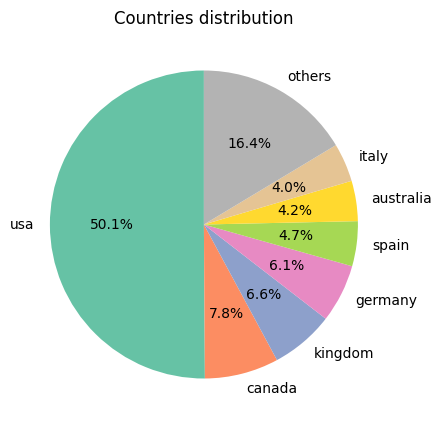

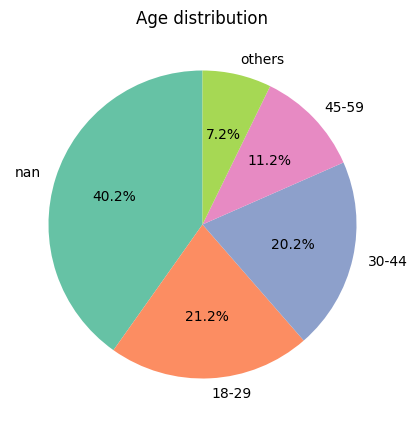

In [9]:
from brs.analysis import PieChartInspection
from brs.analysis import BarChartInspection

PieChartInspection("Countries", title="Countries distribution", top_n=7, dropna=False, figsize=(5,5)).inspect(data_users)
PieChartInspection("Age_group", title="Age distribution", top_n=4, dropna=False, figsize=(5,5)).inspect(data_users)

Таким образом

- Около 70% пользователей из англоговорящих стран 
- Почти про всех пользователей мы знаем его страну
- В основном читатели это молодые взрослые
- В данных по возрасту много пропущенных значений

В дальнейшем можно попробовать добавить информацию об отдельных регионах

## Датасет с книгами data_books

In [10]:
data_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Анализ пропусков

На первый взгляд в датасете почти нет пропусков

In [11]:
from brs.analysis import NAInspection

NAInspection(dataset_name="books").inspect(data_books)

books total size 271360
                     NaN count NaN %
ISBN                         0  0.0%
Book-Title                   0  0.0%
Book-Author                  2  0.0%
Year-Of-Publication          0  0.0%
Publisher                    2  0.0%
Image-URL-S                  0  0.0%
Image-URL-M                  0  0.0%
Image-URL-L                  3  0.0%


In [12]:
data_books[data_books["Book-Author"].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


Однако в Year-Of-Publication можно найти подозрительные записи, которые должны быть заменены на NaN

In [13]:
print((data_books["Year-Of-Publication"] == "0").sum())
data_books[data_books["Year-Of-Publication"]  == "0"].head()

1048


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
196656,3442035368,Ich Gestehe,Heinz G. Konsalik,0,Wilhelm Goldmann Verlag GmbH,http://images.amazon.com/images/P/3442035368.0...,http://images.amazon.com/images/P/3442035368.0...,http://images.amazon.com/images/P/3442035368.0...
196678,0553124803,Being There,Jerzy Kosinski,0,Bantam Doubleday Dell,http://images.amazon.com/images/P/0553124803.0...,http://images.amazon.com/images/P/0553124803.0...,http://images.amazon.com/images/P/0553124803.0...
196680,888274387X,Vaniglia E Cioccolato,Modignani Casati,0,Sperling Paperback,http://images.amazon.com/images/P/888274387X.0...,http://images.amazon.com/images/P/888274387X.0...,http://images.amazon.com/images/P/888274387X.0...
196685,033368155X,Surreal Lives the Surrealists 1945,Ruth Brandon,0,Humanity Press/prometheus Bk,http://images.amazon.com/images/P/033368155X.0...,http://images.amazon.com/images/P/033368155X.0...,http://images.amazon.com/images/P/033368155X.0...
196734,0207158452,Games of the Strong,Glenda Adams,0,Harpercollins Publisher,http://images.amazon.com/images/P/0207158452.0...,http://images.amazon.com/images/P/0207158452.0...,http://images.amazon.com/images/P/0207158452.0...


Также в Year-Of-Publication несколько раз лежат не целочисленные значения.

- Очевидно, колонки съехали на одну влево, а автор является NaN значением
- Однако вряд ли эти записи нам критически важны
- Проще будет откинуть на текущем этапе значения с кривыми Year-Of-Publication

In [14]:
mask = ~data_books["Year-Of-Publication"].astype(str).str.isnumeric()
data_books[mask]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


### Анализ дубликатов

Посмотрим на распределение книг, авторов и издательств в датасете

- Заметим, что в датасете довольно много дубликатов
- Однако оставить на каждое отдельное произведение только одну книгу, скорее всего, плохая идея, так как людям может быть интересна серия от конкретного издательства

Сделаем два вывода:

1. Нужно проверить датасет на наличие полных дубликатов и удалить их, если они есть
2. Есть смысл поэксперементировать с добавлением в данные фичи, которая бы явно связывала одинаковые книги, но разного года издания и от разных издательств

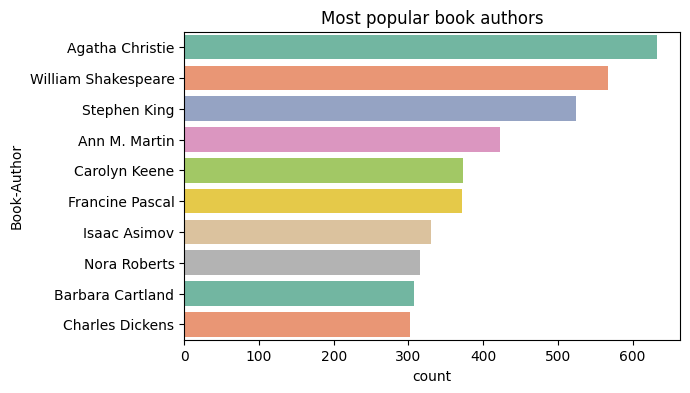

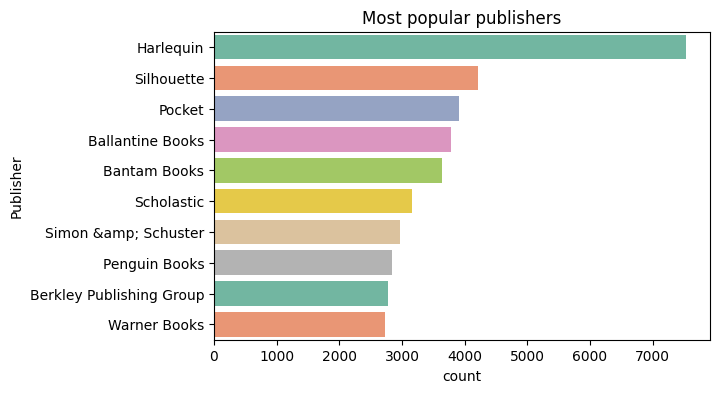

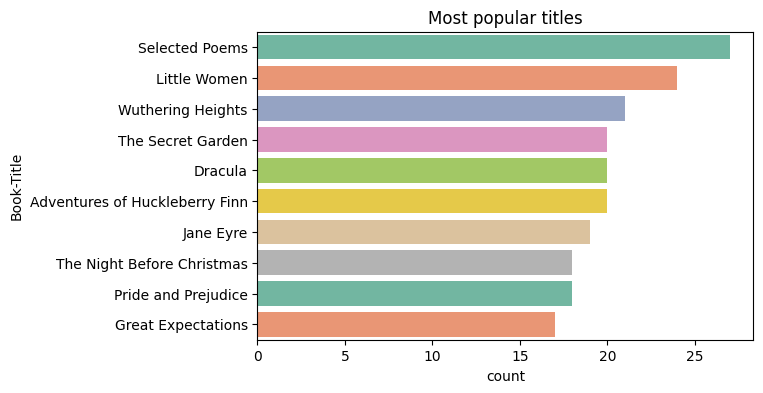

In [15]:
from brs.analysis import BarChartInspection

BarChartInspection("Book-Author", title="Most popular book authors", top_n=10, dropna=False, figsize_scale=0.8).inspect(data_books)
BarChartInspection("Publisher", title="Most popular publishers", top_n=10, dropna=False, figsize_scale=0.8).inspect(data_books)
BarChartInspection("Book-Title", title="Most popular titles", top_n=10, dropna=False, figsize_scale=0.8).inspect(data_books)

Дальше проверяем полные дубликаты

Видно, что полные дубликаты в датасете встречаются, однако у них всех разный ISBN

Это можно объяснить либо ошибкой в данных, либо тем, что для Phonics Fun выпустили 12 редакций за 2003 год. Второе объяснение звучит маловероятно, поэтому, скорее всего, есть смысл избавится в данных от всех дублирующихся книг.

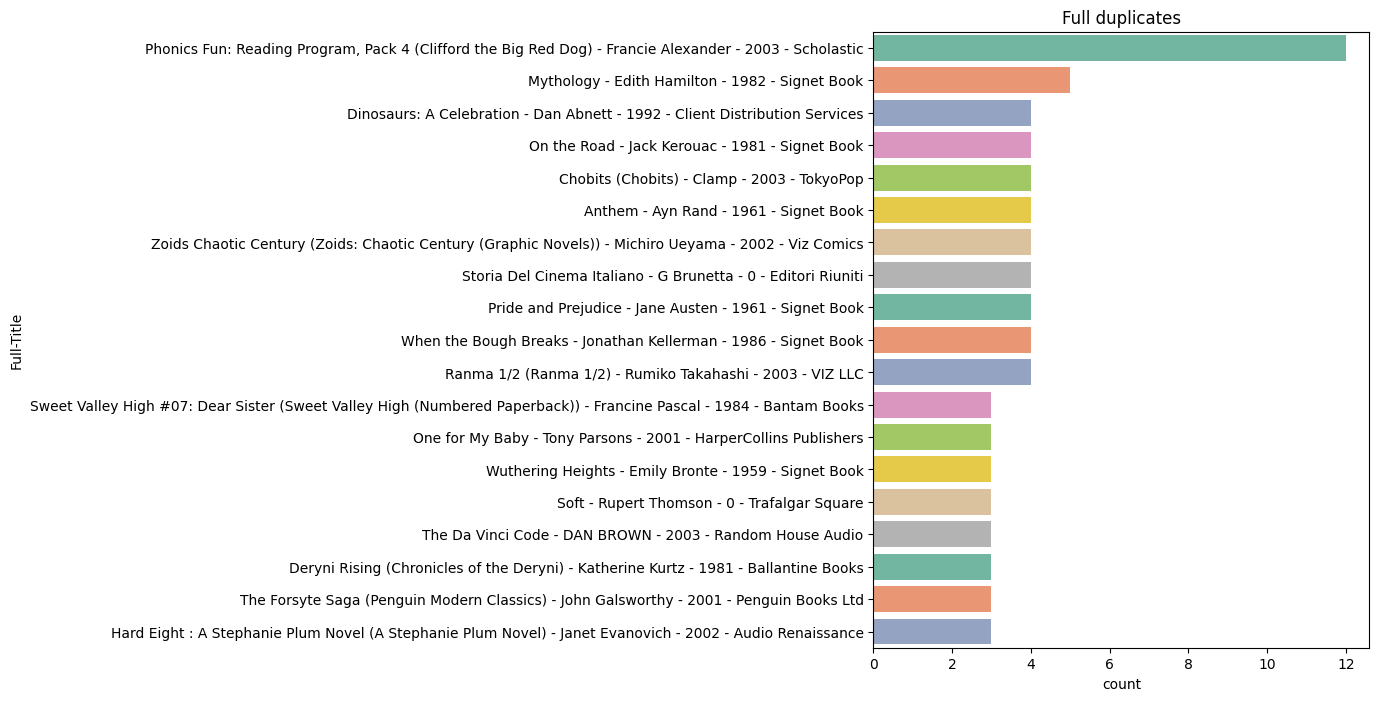

2025-08-24 02:45:57,044 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-24 02:45:57,051 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


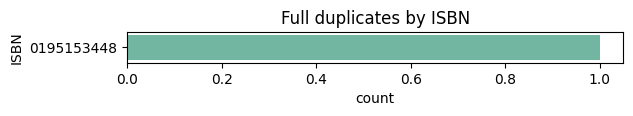

In [16]:
tdf = data_books.copy()
tdf["Full-Title"] = tdf["Book-Title"] + " - " + tdf["Book-Author"] + " - " + tdf["Year-Of-Publication"].astype(str) + " - " + tdf["Publisher"]
BarChartInspection("Full-Title", title="Full duplicates", top_n=20, dropna=False, figsize_scale=0.8).inspect(tdf)

tdf["Full-Title"] = tdf["ISBN"] + " - " + tdf["Full-Title"]
BarChartInspection("ISBN", title="Full duplicates by ISBN", top_n=1, dropna=False, figsize_scale=0.8).inspect(tdf)


Стоит сделать несколько практических замечаний, связанных с дальнейшим анализом и другим датасетом data_ratings

1. В data_ratings данные представлены связями между ISBN, юзером и его оценкой, поэтому просто выкинуть дубликаты может быть плохой идеей. Стоит склеить их в одну запись, а в ISBN хранить список из всех ISBN-ов, ассоциированных с дубликатами
2. Для книг, которые не являются полными дубликатами есть смысл считать общую популярность, а не только популярность отдельной книги. Подробнее про популярность будет дальше
3. Есть смысл рассмотреть добавление отдельной фичи, которая связывала бы книги, которые не являются полными дубликатами, но имеют один title и одного автора

### Распределение по годам

- Года в данных реалистичны. 
- За NaN, по всей видимости, отвечает только нулевой год
- Большая часть книг это вторая половина 20го века
- Есть несколько очень старых книг, но они малоизвестны и вряд ли будут вносить значимый импакт в систему
- Есть книги, которые выходят в будущем, что можно считать ошибкой в данных. Текущий год будем считать 2023им, тогда последний раз обновлялся датасет

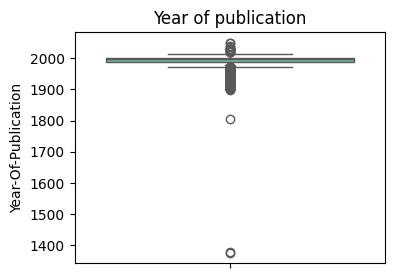

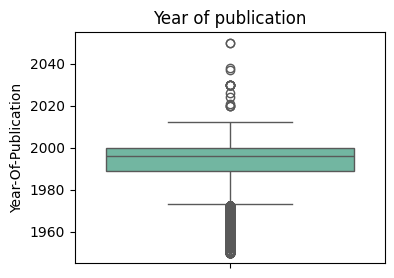

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


In [17]:
# Отбросим все кривые данные, где

tdf = data_books[data_books["Year-Of-Publication"].astype(str).str.isnumeric()].copy()
tdf["Year-Of-Publication"] = tdf["Year-Of-Publication"].astype(int)
tdf = tdf[~(tdf["Year-Of-Publication"] == 0)]

BoxPlotInspection("Year-Of-Publication", title="Year of publication", figsize=(4,3)).inspect(tdf)



BoxPlotInspection("Year-Of-Publication", title="Year of publication", figsize=(4,3)).inspect(
    tdf[~(tdf["Year-Of-Publication"] < 1950)]
)

tdf[tdf["Year-Of-Publication"] <1500].head()

### Проведем простой препроцессинг

Проведём опять первоначальный processing

- Уберём Image-URL, так как это информация, с которым нам вообще ничего не даёт
- Типизируем каждый столбец и почистим кривые Year-Of-Publication
- Сольём дубликаты

In [18]:
from brs.preprocessing import BooksPreprocessingStrategy

data_books = BooksPreprocessingStrategy().preprocess(data_books)

In [19]:
data_books[data_books["Same-Book"].apply(lambda x: len(x)) > 1].head()

,Book-Title,Book-Author,Publisher,Year-Of-Publication,ISBN,Same-Book
41,!%@ (A Nutshell handbook),Donnalyn Frey,O'Reilly,1993,[1565920317],"[1565920317, 1565920465]"
42,!%@ (A Nutshell handbook),Donnalyn Frey,O'Reilly,1994,[1565920465],"[1565920317, 1565920465]"
59,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes,National Geographic,2000,[0792276833],"[0792276833, 0792277295]"
60,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes,National Geographic,2001,[0792277295],"[0792276833, 0792277295]"
78,'Salem's Lot,Stephen King,Doubleday Books,1993,[0385007515],"[0385007515, 0451168089, 067103975X]"


### Добавим новых фичей в датасет


Добавим три новых фичи (для первых двух добавим log1p значение)

1. Старость книги. Работать с годом выпуска книги можем быть неудобно. Лучше возьмем возраст книги

Напомню, что data_ratings представляет из себя матрицу, сопоставляющую пользователя и книгу, значениями в которой являются оценки. На основе неё можно получить сразу две фичи

2. Популярность. Как много у книги оценок. Популярность будем считать два раза. Один раз для книги в целом, второй раз для конкретного издания

3. Рейтинг. Средний рейтинг книги. Так же считаем два раза. Для книги и для издания

In [20]:
from brs.feature_engineering import PopularityFeature, RatingFeature, ElderityFeature

data_books = PopularityFeature(ratings_df=data_ratings).apply_transformation(data_books)
data_books = RatingFeature(ratings_df=data_ratings).apply_transformation(data_books)
data_books = ElderityFeature(ratings_df=data_ratings).apply_transformation(data_books)

In [21]:
data_books.head(40)

,Book-Title,Book-Author,Publisher,Year-Of-Publication,ISBN,Same-Book,Popularity-Edition,Popularity-Edition-Log,Popularity-Book,Popularity-Book-Log,Rating-Edition,Rating-Book,Elderity,Elderity_log
0,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,Hyperion Books for Children,1999,[0590567330],[0590567330],4,1.609438,4,1.609438,2.250000,2.250000,24,3.218876
1,Always Have Popsicles,Rebecca Harvin,Rebecca L. Harvin,1994,[0964147726],[0964147726],1,0.693147,1,0.693147,0.000000,0.000000,29,3.401197
2,Apple Magic (The Collector's series),Martina Boudreau,Amer Cooking Guild,1984,[0942320093],[0942320093],1,0.693147,1,0.693147,0.000000,0.000000,39,3.688879
3,"Ask Lily (Young Women of Faith: Lily Series, ...",Nancy N. Rue,Zonderkidz,2001,[0310232546],[0310232546],1,0.693147,1,0.693147,8.000000,8.000000,22,3.135494
4,Beyond IBM: Leadership Marketing and Finance ...,Lou Mobley,"Teleonet, Incorporated",1989,[0962295701],[0962295701],1,0.693147,1,0.693147,0.000000,0.000000,34,3.555348
5,Clifford Visita El Hospital (Clifford El Gran...,Norman Bridwell,Scholastic,2000,[0439188970],[0439188970],1,0.693147,1,0.693147,0.000000,0.000000,23,3.178054
6,Dark Justice,Jack Higgins,Putnam Publishing Group,2004,[0399151788],[0399151788],1,0.693147,1,0.693147,10.000000,10.000000,19,2.995732
7,Deceived,Carla Simpson,Pinnacle Books,1994,[0786000015],[0786000015],2,1.098612,2,1.098612,0.000000,0.000000,29,3.401197
8,Earth Prayers From around the World: 365 Pray...,Elizabeth Roberts,HarperSanFrancisco,1991,[006250746X],[006250746X],10,2.397895,10,2.397895,5.000000,5.000000,32,3.496508
9,Final Fantasy Anthology: Official Strategy Gu...,David Cassady,BradyGames,1999,[1566869250],[1566869250],4,1.609438,4,1.609438,5.000000,5.000000,24,3.218876


In [22]:
from brs.analysis import HistogramInspection

In [23]:
tdf = data_books[data_books["Popularity-Edition"] > 1]

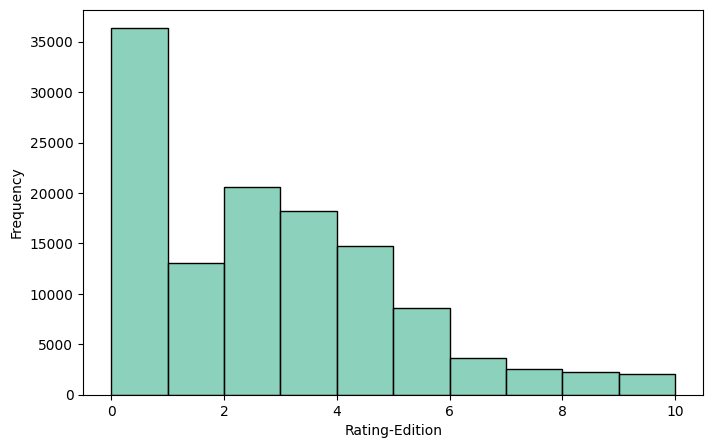

In [26]:
HistogramInspection(column_name="Rating-Edition").inspect(tdf)